In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
# Rotation
from scipy.spatial.transform import Rotation as R

import rclpy
from rclpy.node import Node


# Odometry
from nav_msgs.msg import Odometry

from geometry_msgs.msg import Twist

# Tf2
from tf2_ros import TransformException
from tf2_ros.buffer import Buffer
from tf2_ros.transform_listener import TransformListener

import pickle
import glob
import os
from PyQt5.QtWidgets import QFileDialog, QWidget, QApplication
from scipy.interpolate import CubicSpline, Rbf


# Load pickle file
QApp = QApplication([])
QWidget = QWidget()
# open dialog to select file



In [2]:

def get_odom_data(dict, dict_key):
	orientations = []
	positions = []
	velocities = []
	ang_velocities = []
	timesteps = []
	for msg in dict[dict_key]:
		orientations.append(R.from_quat([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w]))
		positions.append(np.array([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z]))
		velocities.append(np.array([msg.twist.twist.linear.x, msg.twist.twist.linear.y, msg.twist.twist.linear.z]))
		ang_velocities.append(np.array([msg.twist.twist.angular.x, msg.twist.twist.angular.y, msg.twist.twist.angular.z]))
		timesteps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

	odom_dict = {"orientations" : orientations, "positions" : positions, "velocities" : velocities, "ang_velocities" : ang_velocities, "timesteps" : timesteps}
	return odom_dict

def get_twist_data(dict, dict_key):
	linear = []
	angular = []
	for msg in dict[dict_key]:
		linear.append(np.array([msg.linear.x, msg.linear.y, msg.linear.z]))
		angular.append(np.array([msg.angular.x, msg.angular.y, msg.angular.z]))
	twist_dict = {"linear" : linear, "angular" : angular}
	return twist_dict

def get_joint_states(dict, dict_key):
	names = []
	positions = []
	velocities = []
	efforts = []
	timesteps = []
	for msg in dict[dict_key]:
		names.append(msg.name)
		positions.append(np.array(msg.position))
		velocities.append(np.array(msg.velocity))
		efforts.append(np.array(msg.effort))
		timesteps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

	joint_states_dict = {"name" : names, "positions" : positions, "velocities" : velocities, "efforts" : efforts, "timesteps" : timesteps}
	return joint_states_dict

def get_localization_data(file_path):

	with open(file_path, "rb") as f:
		data = pickle.load(f)

	positions = data[:][0]
	orientations = data[:][1]
	timesteps = data[:][2]


	localization_dict = {"orientations" : orientations, "positions" : positions, "timesteps" : timesteps}
	return localization_dict


def get_pose_array(dict, dict_key):
	plan = np.array([[pose.position.x, pose.position.y, pose.position.z] for pose in dict[dict_key].poses])
	return plan


def get_link_heading(dict,):
	directions = np.zeros((len(dict["orientations"]), 3))
	for i, o in enumerate(dict["orientations"]):
		directions[i] = o.apply([1, 0, 0])

	heading_angles = np.zeros(len(dict["orientations"]))
	for i in range(len(dict["orientations"])):
		# If velocity is less than 0.2 m/s and twist.z is less than 0.1 rad/s, set heading angle to 0 and continue
		if np.linalg.norm(dict["velocities"][i]) < 0.2 and np.linalg.norm(dict["ang_velocities"][i]) < 0.1:
			heading_angles[i] = 0
			continue
		# Get angle between rear_directions[i] and rear_link_dict["velocities"][i]
		heading_angles[i] = np.arccos(np.dot(directions[i], dict["velocities"][i]) / (np.linalg.norm(directions[i]) * np.linalg.norm(dict["velocities"][i])))

	return heading_angles


In [3]:

def interpolate_points(points, num_points):
            
    # Concatenate the points to form a 3x3 array
    # points = np.array([p1, p2, p3])

    # Calculate the distances between each pair of points
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))

    # Calculate the cumulative distance along the curve
    cumulative_distances = np.cumsum(distances)
    cumulative_distances = np.insert(cumulative_distances, 0, 0) # Add initial distance of 0

    # Create a cubic spline interpolation of the points
    interp = CubicSpline(cumulative_distances, points, bc_type='not-a-knot')

    # Generate points along the curve at the specified resolution
    s_vals = np.linspace(cumulative_distances[0], cumulative_distances[-1], num_points)

    # for idx, dist in enumerate(cumulative_distances[:-1], ):
    #     num_points = int(np.ceil((cumulative_distances[idx + 1] - dist)/resolution))
    #     # print(num_points)
    #     s_val = np.linspace(dist, cumulative_distances[idx + 1], num_points)
    #     s_vals = np.append(s_vals, s_val[1:])

    # Generate 10 points along the curve
    interp_points = interp(s_vals)

    return interp_points


In [4]:
file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', '/home/daniel/Documents/master/rosbags/pose_data')[0]
print(file_path)

with open(file_path, "rb") as f:
    data = pickle.load(f)

/home/daniel/Documents/master/rosbags/pose_data/friction_v4_df_2_5_a_0_5.pkl


In [5]:
rear_link_dict = get_odom_data(data, "rear_link_pose_gt")
base_link_dict = get_odom_data(data, "base_link_pose_gt")
try:
    waypoints = get_pose_array(data, "wayposes")
except:
    print("No waypoints")
    waypoints = None
    pass
try:
    plan = get_pose_array(data, "global_pln")
except:
    print("No plan")
    plan = None
    pass
cmd_vel = get_twist_data(data, "cmd_vel")
joint_states_controller = get_joint_states(data, "joint_state_controller")
joint_states = get_joint_states(data, "joint_states")
try:
    odometry_ekf = get_odom_data(data, "odometry_ekf")
except:
    print("No ekf data")
    odometry_ekf = None
    pass

No waypoints
No plan


In [6]:

#ax.scatter(points[:,0], points[:,1], points[:,2], c='b', marker='^')
if plan is not None:
    fig = plt.figure()

    fig.canvas.toolbar_visible = True


    ax = fig.add_subplot(111, projection='3d')

    plot_scatter = ax.scatter(plan[:,0], plan[:,1], plan[:,2], c='r', marker='^')

    ax.set_box_aspect((np.ptp(plan[:,0]), np.ptp(plan[:,1]), np.ptp(plan[:,2])))  # aspect ratio is 1:1:1 in data space
    # setting title and labels
    ax.set_title("3D plot")
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')
    
# displaying the plot
# plt.show()

In [26]:

fig, ax = plt.subplots()
# ax = fig.add_subplot(ax = fig)
%matplotlib widget
rear_heading_angles = get_link_heading(rear_link_dict)
base_heading_angles = get_link_heading(base_link_dict)

# Plot heading angles over time
ax.plot(rear_link_dict["timesteps"], rear_heading_angles)
ax.plot(base_link_dict["timesteps"], base_heading_angles)
ax2 = ax.twinx()
ax2.plot(joint_states["timesteps"], np.array(joint_states["positions"])[:,3], color="red")
ax2.plot(joint_states_controller["timesteps"], np.array(joint_states_controller["positions"])[:,4]/ 4 * 0.8, color="green")
# plt.plot(cmd_timesteps, cmd_vels[:, 1])
# Add legend
ax.legend(["Rear link", "Base link"], loc="upper left")
ax2.legend(["hydraulic joint position", "Angular kink command"], loc="lower right")

ax.set_ylim([-3.15, 3.15])
ax2.set_ylim([-0.9, 0.9])

# Add labels
ax.set_title("Heading angle and joint position over time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Heading angle (rad)")
ax2.set_ylabel("Joint position (rad)")
plt.show()


In [39]:
file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', '/home/daniel/Documents/master/rosbags/pose_data')[0]
print(file_path)

with open(file_path, "rb") as f:
    data = pickle.load(f)

base_link_dict = get_odom_data(data, "base_link_pose_gt")
joint_states = get_joint_states(data, "joint_states")
joint_states_controller = get_joint_states(data, "joint_state_controller")


file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', '/home/daniel/Documents/master/rosbags/pose_data')[0]
print(file_path)

with open(file_path, "rb") as f:
    data = pickle.load(f)

base_link_dict_2 = get_odom_data(data, "base_link_pose_gt")
joint_states_2 = get_joint_states(data, "joint_states")
joint_states_controller_2 = get_joint_states(data, "joint_state_controller")

file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', '/home/daniel/Documents/master/rosbags/pose_data')[0]
print(file_path)

with open(file_path, "rb") as f:
    data = pickle.load(f)

base_link_dict_3 = get_odom_data(data, "base_link_pose_gt")
joint_states_3 = get_joint_states(data, "joint_states")
joint_states_controller_3 = get_joint_states(data, "joint_state_controller")


/home/daniel/Documents/master/rosbags/pose_data/friction_v4_df_1.pkl
/home/daniel/Documents/master/rosbags/pose_data/friction_v4_df_2_5.pkl
/home/daniel/Documents/master/rosbags/pose_data/friction_v4_df_5.pkl


[0. 0. 0. ... 0. 0. 0.]


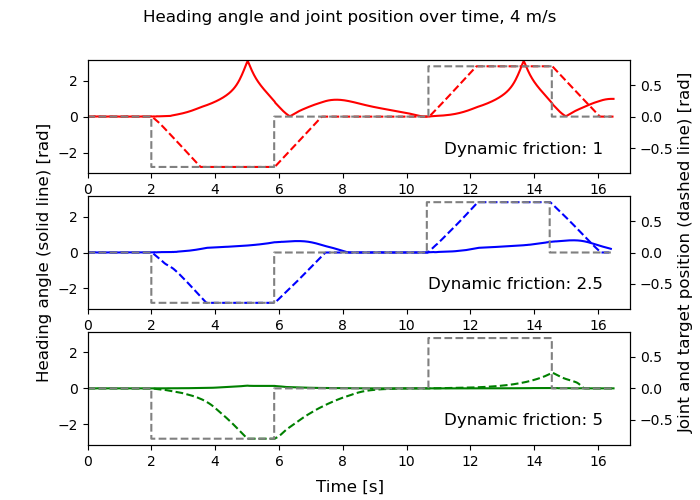

In [43]:
fig, ax = plt.subplots(3,1)
# create 3 subplots in 1 figure


# ax = fig.add_subplot(ax = fig)

# rear_heading_angles = get_link_heading(rear_link_dict)
base_heading_angles = get_link_heading(base_link_dict)
base_heading_angles_2 = get_link_heading(base_link_dict_2)
base_heading_angles_3 = get_link_heading(base_link_dict_3)

ax0_xlim_start = np.where(np.array(joint_states_controller["positions"])[:,4] <= -0.1)[0][0]
ax0_xlim_start = joint_states_controller["timesteps"][ax0_xlim_start] - 2
timestep_joint_controller_1 = np.array(joint_states_controller["timesteps"]) - ax0_xlim_start
timestep_base_link_1 = np.array(base_link_dict["timesteps"]) - ax0_xlim_start
timestep_joint_states_1 = np.array(joint_states["timesteps"]) - ax0_xlim_start

ax1_xlim_start = np.where(np.array(joint_states_controller_2["positions"])[:,4] <= -0.1)[0][0]
ax1_xlim_start = joint_states_controller_2["timesteps"][ax1_xlim_start] - 2
timestep_joint_controller_2 = np.array(joint_states_controller_2["timesteps"]) - ax1_xlim_start
timestep_base_link_2 = np.array(base_link_dict_2["timesteps"]) - ax1_xlim_start
timestep_joint_states_2 = np.array(joint_states_2["timesteps"]) - ax1_xlim_start




ax2_xlim_start = np.where(np.array(joint_states_controller_3["positions"])[:,4] <= -0.1)[0][0]
ax2_xlim_start = joint_states_controller_3["timesteps"][ax2_xlim_start] - 2
timestep_joint_controller_3 = np.array(joint_states_controller_3["timesteps"]) - ax2_xlim_start
timestep_base_link_3 = np.array(base_link_dict_3["timesteps"]) - ax2_xlim_start
timestep_joint_states_3 = np.array(joint_states_3["timesteps"]) - ax2_xlim_start



# Plot heading angles over time
# ax.plot(rear_link_dict["timesteps"], rear_heading_angles)
ax[0].plot(timestep_base_link_1, base_heading_angles, color="red", label="base link heading")
ax[1].plot(timestep_base_link_2, base_heading_angles_2 , color="blue", label="base link heading")
ax[2].plot(timestep_base_link_3, base_heading_angles_3 , color="green", label="base link heading")
ax2_0 = ax[0].twinx()
ax2_1 = ax[1].twinx()
ax2_2 = ax[2].twinx()

ax2_0.plot(timestep_joint_states_1, np.array(joint_states["positions"])[:,3], color="red", linestyle="dashed", label="Joint position")
ax2_1.plot(timestep_joint_states_2, np.array(joint_states_2["positions"])[:,3], color="blue", linestyle="dashed", label="dynamic friction: 2.5")
ax2_2.plot(timestep_joint_states_3, np.array(joint_states_3["positions"])[:,3], color="green", linestyle="dashed", label="dynamic friction: 5")

ax2_0.plot(timestep_joint_controller_1, np.array(joint_states_controller["positions"])[:,4]/ 4 * 0.8, color="grey", linestyle="dashed", label="Angular kink command")
ax2_1.plot(timestep_joint_controller_2, np.array(joint_states_controller_2["positions"])[:,4]/ 4 * 0.8, color="grey", linestyle="dashed", label="Angular kink command")
ax2_2.plot(timestep_joint_controller_3, np.array(joint_states_controller_3["positions"])[:,4]/ 4 * 0.8, color="grey",linestyle="dashed",  label="Angular kink command")
# plt.plot(cmd_timesteps, cmd_vels[:, 1])
# Add legend
#ax.legend(title="base_link heading with:", loc="upper left")
#ax2.legend(title="Joint position with:", loc="lower right")

ax[0].set_ylim([-3.15, 3.15])
# ax[0].legend(title="Dynamic friction: 1", loc="upper left")
ax2_0.set_ylim([-0.9, 0.9])
ax2_0.set_xlim([0, 17])
print(np.array(joint_states_controller["positions"])[:,4])

#ax[0].set_xlim(ax0_xlim_start - 2, ax0_xlim_start + 15)

ax[1].set_ylim([-3.15, 3.15])
ax[1].set_xlim([0, 17])

#ax[1].set_xlim(ax1_xlim_start - 2, ax1_xlim_start + 15)


ax2_1.set_ylim([-0.9, 0.9])
ax[2].set_ylim([-3.15, 3.15])
ax[2].set_xlim([0, 17])

#ax[2].set_xlim(ax2_xlim_start - 2, ax2_xlim_start + 15)



ax2_2.set_ylim([-0.9, 0.9])


ax[1].set_ylabel("Heading angle (solid line) [rad]", fontsize=12)
ax2_1.set_ylabel("Joint and target position (dashed line) [rad]", fontsize=12)

# add title for entire figure
fig.suptitle("Heading angle and joint position over time, 4 m/s")
fig.axes[0].set_title("Dynamic friction: 1", loc="right", y=0.1, x=0.95)
fig.axes[1].set_title("Dynamic friction: 2.5", loc="right", y=0.1, x=0.95)
fig.axes[2].set_title("Dynamic friction: 5", loc="right", y=0.1, x=0.95)

# Add labels
fig.supxlabel("Time [s]")
fig.set_figwidth(7)
fig.set_figheight(5)
# fig.supylabel("Heading angle (rad)")

plt.show()